# Local Employment Dynamics and Commuting Costs

See the paper: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4514106

## Model

This notebook creates results appearing in section 6 of the paper. The model is a simplified version of a Diamond-Mortensen-Pissarides (DMP)
model (Pissarides, 2000), where the spatial dimension enters through the condition that
utility should be equalized across space, as in Rosen (1979) and Roback (1982).


The model is solved using [Julia](https://julialang.org/).

## Structure of this notebook

    # 0. Dependencies
    # I. Calibration
    # II. Simulate FTZ reform
    # III. Visualize FTZ reform

# 0. Dependencies

In [1]:
versioninfo()

Julia Version 1.7.1
Commit ac5cc99908 (2021-12-22 19:35 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Core(TM) i7-8850H CPU @ 2.60GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-12.0.1 (ORCJIT, skylake)
Environment:
  JULIA_NUM_THREADS = 4


In [2]:
using Parameters
using Plots
using Distributions
using Optim
using LaTeXStrings

## I. Calibration

### Value of home production

In [3]:
y = 1.0 # value of output
b_1 = 0.9*y #fix the value of home production (leisure + unemployment benefits) in city 1

## Assume a 75%, 25% split between unemployment benefits and amenities
ub = 1.0 
a_1 = 4*(b_1 - (3/4)*ub) 

a_2 = 0.5*a_1
b_2 = (3/4)*ub + (1/4)*a_2

println("Home production in city 1: $(b_1)")
println("Home production in city 2: $(b_2)")
println("Amenities city 2/amenities city 1: $(a_2/a_1)")

Home production in city 1: 0.9
Home production in city 2: 0.825
Amenities city 2/amenities city 1: 0.5


### Commuting costs

In [4]:
# 230 days commmuting (5 weeks of paid holidays in France)
# one return trip per day
# Average commuting time in fare 3: 40 mintues
# Average commuting time in fare area 2-3: 24 minutes

nb_days = 230
nb_trips_per_day = 2
minutes_per_trip_2 = 40 #minutes in fare area 3
minutes_per_trip_1 = 24 #minutes in fare area 1-2

# Net minimum wage in euros (2015): 9.61 euros per hour
# Cotisations salariales obligatoires (21,66%)
# 9.61*(1 - 21.66/100) ~ 7.53
# Source: https://www.smic-horaire.fr/
cost_per_minutes = 7.53

# Time cost per month
time_cost_2 = (nb_trips_per_day*(minutes_per_trip_2/60)*cost_per_minutes)*(nb_days/360)*30
time_cost_1 = (nb_trips_per_day*(minutes_per_trip_1/60)*cost_per_minutes)*(nb_days/360)*30

println("Time cost fare area 3: $(time_cost_2) euros monthly")
println("Time cost fare area 1-2: $(time_cost_1) euros monthly")

Time cost fare area 3: 192.4333333333333 euros monthly
Time cost fare area 1-2: 115.46000000000001 euros monthly


In [5]:
travel_card_2_t0 = 89.20
travel_card_2_t1 = 70.00

travel_card_1_t0 = 70.00
travel_card_1_t1 = 70.00

total_commuting_cost_2_t0 = time_cost_2 + travel_card_2_t0
total_commuting_cost_2_t1 = time_cost_2 + travel_card_2_t1
total_commuting_cost_1_t0 = time_cost_1 + travel_card_1_t0
total_commuting_cost_1_t1 = time_cost_1 + travel_card_1_t1

println("Total commuting cost fare area 3 t0: $(total_commuting_cost_2_t0) euros monthly")
println("Total commuting cost fare area 3 t1: $(total_commuting_cost_2_t1) euros monthly")
println("Total commuting cost fare area 1-2 t0: $(total_commuting_cost_1_t0) euros monthly")
println("Total commuting cost fare area 1-2 t1: $(total_commuting_cost_1_t1) euros monthly")

Total commuting cost fare area 3 t0: 281.6333333333333 euros monthly
Total commuting cost fare area 3 t1: 262.4333333333333 euros monthly
Total commuting cost fare area 1-2 t0: 185.46 euros monthly
Total commuting cost fare area 1-2 t1: 185.46 euros monthly


### Empirical wage

* Source: https://www.insee.fr/fr/statistiques/3676648?sommaire=3696937
* See "Figure 6 – Distribution des salaires mensuels nets en 2015 "

""Champ : France hors Mayotte, salariés en EQTP du secteur privé et des entreprises publiques, y c. bénéficiaires de contrats aidés et de contrats de professionnalisation. Sont exclus les apprentis, stagiaires, salariés agricoles et salariés des particuliers employeurs.
Lecture : en 2015, 10 % des salariés en équivalent temps plein du secteur privé et des entreprises publiques, y c. bénéficiaires de contrats aidés et de contrats de professionnalisation, gagnent un salaire mensuel net inférieur à 1 213 euros."" 

Formula:


$$ w(l) = b(l) + (\alpha - \mu)*c(l) $$ 
$$ w(l)/c(l) = b(l)/c(l) + (\alpha - \mu) $$ 
$$ 1800/185 = b(l)/c(l) + (\alpha - \mu)$$ 
$$ 1800/185 - (\alpha - \mu) = b(l)/c(l)$$ 
$$ c(l) = b(l)/(1800/185 - (\alpha - \mu))$$ 

In [6]:
empirical_wage_commuting = 1800
alpha = 1/2 #half of the commuting costs paid by workers
mu = 1/5 #commuting to the city center for the unemployed workers one day a week (as in Wasmer-Zenou 2002)
c_1_t0 = b_1/(empirical_wage_commuting/total_commuting_cost_1_t0 - (alpha - mu))
c_1_t1 = c_1_t0

c_2_t0 = (total_commuting_cost_2_t0/total_commuting_cost_1_t0)*c_1_t0
c_2_t1 = (total_commuting_cost_2_t1/total_commuting_cost_1_t1)*c_1_t0

println("Total commuting cost fare area 3 t0 (in utility): $(c_2_t0) monthly")
println("Total commuting cost fare area 3 t1 (in utility): $(c_2_t1) monthly")
println("Total commuting cost fare area 1-2 t0 (in utility): $(c_1_t0) monthly")
println("Total commuting cost fare area 1-2 t1 (in utility): $(c_1_t1) monthly")

Total commuting cost fare area 3 t0 (in utility): 0.1453081413147042 monthly
Total commuting cost fare area 3 t1 (in utility): 0.135401940652227 monthly
Total commuting cost fare area 1-2 t0 (in utility): 0.09568770702411543 monthly
Total commuting cost fare area 1-2 t1 (in utility): 0.09568770702411543 monthly


### Wage to rent ratio in Paris

Source: Marchiori-Pascal-Pierrard (2023): https://doi.org/10.1016/j.regsciurbeco.2023.103936
rent = 37/100 wage



In [7]:
empirical_wage_rent_ratio = 37/100
w_1 = b_1 + (alpha - mu)*c_1_t0
r_1 = empirical_wage_rent_ratio*(w_1)

println("Rent in city 1: $(r_1)")

Rent in city 1: 0.3436213354796768


In [8]:
# to store parameters
mutable struct Params
    r_yearly::Float64 #yearly discount factor (%)
    r::Float64 #convert to montly discount factor
    y::Float64 #value of output
    b_1::Float64 #value of home production in fare area 1-2
    b_2::Float64 #value of home production in fare area 3
    alpha::Float64 #share of commuting paid by workers
    mu::Float64 #relative frequency of going to the city center for unemployed workers (vs employed workers)
    c_1::Float64  #commuting costs in fare area 1-2
    c_2::Float64  #commuting costs in fare area 3
    r1_w1::Float64  #ratio rent-to-wage in fare area 1-2 (empirical)
    mu_p::Float64 # Parameter for the distribution of idiosyncratic productivities (mean) 
    sigma_p::Float64 # Parameter for the distribution of idiosyncratic productivities (standard deviation)
    delta::Float64 #monthly job desctruction rate
    d_normal::Normal{Float64} 
    chi::Float64 #efficiency parameter for the matching function
    eta::Float64  #elasticty of the matching function with respect to change in Unemployment
    one_min_eta::Float64 
    kappa::Float64 # cost of posting vacancies
end

# Constructor for parameters
function Params(;
    r_yearly = 0.04, #yearly discount factor (%)
    r=(1 + r_yearly)^(1/12) - 1, #convert to montly discount factor
    y= 1.0, #value of output
    b_1 = 0.9*y, #value of home production in fare area 1-2
    b_2 = 0.825*y, #value of home production in fare area 3
    alpha = 0.5, #share of commuting paid by workers
    mu= 1/5, #relative frequency of going to the city center for unemployed workers (vs employed workers)
    c_1 = 0.09568770702411543, #commuting costs in fare area 1-2
    c_2 = 0.1453081413147042, #commuting costs in fare area 3
    r1_w1 = 0.37, #ratio rent-to-wage in fare area 1-2 (empirical)
    mu_p = 0.0, # Parameter for the distribution of idiosyncratic productivities (mean) 
    sigma_p = 1.0, # Parameter for the distribution of idiosyncratic productivities (standard deviation)
    delta= 0.012, #monthly job desctruction rate
    d_normal = Normal(),
    chi = 1.0, #efficiency parameter for the matching function
    eta = 0.5, #elasticty of the matching function with respect to change in Unemployment
    one_min_eta = 1.0 - eta,
    kappa = 0.1*y, # cost of posting vacancies
    )

    Params(r_yearly,  #yearly discount factor (%)
        r, #convert to montly discount factor
        y, #value of output
        b_1, #value of home production in fare area 1-2
        b_2, #value of home production in fare area 3
        alpha, #share of commuting paid by workers
        mu, #relative frequency of going to the city center for unemployed workers (vs employed workers)
        c_1, #commuting costs in fare area 1-2
        c_2, #commuting costs in fare area 3
        r1_w1, #ratio rent-to-wage in fare area 1-2 (empirical)
        mu_p, # Parameter for the distribution of idiosyncratic productivities (mean) 
        sigma_p, # Parameter for the distribution of idiosyncratic productivities (standard deviation)
        delta, #monthly job desctruction rate
        d_normal,
        chi, #efficiency parameter for the matching function
        eta, #elasticty of the matching function with respect to change in Unemployment
        one_min_eta,
        kappa # cost of posting vacancies
    )
    
end

Params

In [9]:
# to store targets when calibrating
@with_kw mutable struct targets
    f::Float64 = 0.075 #monthly job finding rate.
    q::Float64 = 1/2 #job filling rate (monthly). 
    theta::Float64 = 1/2 #labor market tightness.
end

targets

In [10]:
"""
    wage(b::Float64, alpha::Float64, mu::Float64, c::Float64)

Calculate the wage in a given city.

# Arguments
- `b::Float64`: Value of home production.
- `alpha::Float64`: Share of commuting costs paid by workers.
- `mu::Float64`: Relative frequency of commuting to the city center for unemployed workers.
- `c::Float64`: Commuting costs.

# Returns
- `Float64`: Wage in the given city, calculated as `b + (alpha - mu)*c`.
"""
function wage(b::Float64, alpha::Float64, mu::Float64, c::Float64)
    return b + (alpha - mu)*c
end


wage

In [11]:
"""
    wage_tilde(b::Float64, mu::Float64, c::Float64)

Calculate the reservation wage in a given city.

# Arguments
- `b::Float64`: Value of home production.
- `mu::Float64`: Relative frequency of commuting to the city center for unemployed workers.
- `c::Float64`: Commuting costs.

# Returns
- `Float64`: Reservation wage in the given city, calculated as `b + (1.0 - mu)*c`.
"""
function wage_tilde(b::Float64, mu::Float64, c::Float64)
    return b + (1.0 - mu)*c
end


wage_tilde

In [12]:
"""
    E_p(mu_p, sigma_p, w_tilde, y)

Calculate the expected value for `p`, conditional on `p*y` being greater than the reservation wage (`w_tilde`). 
Assumes that `p` follows a normal distribution with mean `mu_p` and standard deviation `sigma_p`.

# Arguments
- `mu_p`: Mean value for `p`.
- `sigma_p`: Standard deviation for `p`.
- `w_tilde`: Reservation wage.
- `y`: Value of output.

# Returns
- Expected value for `p`, given the condition `p*y` > `w_tilde`.

# Notes
The function calculates the critical value and uses the PDF and CDF of the normal distribution.
"""
function E_p(mu_p, sigma_p, w_tilde, y)
    c = ((w_tilde/y) - mu_p)/sigma_p
    dist = Normal()
    return mu_p + sigma_p*pdf(dist, c)/(1.0 - cdf(dist, c))
end


E_p

In [13]:
# to store the model
mutable struct Models
    p::Params #store parameter values
    w_1::Array{Float64} #wage in fare area 1
    w_2::Array{Float64} #wage in fare area 2
    w_tilde_1::Array{Float64}  # reservation wage in fare area 1
    w_tilde_2::Array{Float64}  # reservation wage in fare area 2
    # Mean values of output
    E_p_1::Array{Float64} 
    E_p_2::Array{Float64} 
    # Mean value
    r_1::Array{Float64}  #rent in fare area 1
    r_2::Array{Float64}  #rent in fare area 2
    # Labor market tightness
    theta_1::Array{Float64} 
    theta_2::Array{Float64} 
    # Measure of unemployed workers
    u_1::Array{Float64} 
    u_2::Array{Float64}
    # Value functions unemployed
    B_1::Array{Float64}
    B_2::Array{Float64}
end

# Constructor for models
function Models(p::Params)

    # Initialization
    w_1 = zeros(1)
    w_2 = zeros(1)

    # Calculate reservation wage
    w_tilde_1 = zeros(1)
    w_tilde_2 = zeros(1)

    # Calculate the expected value of output:
    # Let's assume a Normal distribution of p
    # This gives rise to a truncated normal
    # Closed form formula available: https://en.wikipedia.org/wiki/Truncated_normal_distribution
    #-------------------------------------------------------------------------------------------
    E_p_1 = zeros(1)
    E_p_2 = zeros(1)

    # Calculate rent
    r_1 = zeros(1)

    # Rent in fare area 3 needs to adjust in order to the value of unemployment to clear
    # Calculated after 
    r_2 = zeros(1) #initialization
    
    # market tightness
    theta_1 = zeros(1) #initialization
    theta_2 = zeros(1) #initialization
    
    # Measure of unemploymed workers
    u_1 = zeros(1)
    u_2 = zeros(1)
    
    B_1= zeros(1)
    B_2= zeros(1)
    
        Models(
        p,
        w_1,
        w_2,
        w_tilde_1,
        w_tilde_2,
        E_p_1,
        E_p_2,
        r_1,
        r_2,
        theta_1,
        theta_2,
        u_1,
        u_2,
        B_1,
        B_2)

end

Models

In [14]:
"""
    eq_theta(w_tilde::Float64, E_p::Float64, p::Params)

Calculate the ratio of `V` to `U`, denoted as `theta`, based on the reservation wage, expected value of `p`, and specific parameters.

# Arguments
- `w_tilde::Float64`: Reservation wage.
- `E_p::Float64`: Expected value for `p`.
- `p::Params`: A structure containing specific parameters. 

# Returns
- `Float64`: The calculated value of `theta`, representing the ratio of `V` to `U`.

"""
function eq_theta(w_tilde::Float64, E_p::Float64, p::Params)
    c = ((w_tilde/p.y) - p.mu_p)/p.sigma_p
    return (((E_p - w_tilde)*(p.chi*(1.0 - cdf(p.d_normal, c))))/((p.r + p.delta)*p.kappa))^(1/p.eta)
end


eq_theta

In [15]:
"""
    BC_u(w_tilde::Float64, theta::Float64, p::Params)

Calculate the measure of unemployed workers, assuming a Cobb-Douglas matching function in the labor market. 
The function is based on the Beveridge curve (BC) and considers labor market tightness (`theta`) and reservation wage (`w_tilde`).

# Arguments
- `w_tilde::Float64`: Reservation wage.
- `theta::Float64`: Labor market tightness, representing the ratio of `V` to `U`.
- `p::Params`: A structure containing specific parameters, including:
    * `y::Float64`: Value of output.
    * `mu_p::Float64`: Mean of the distribution of idiosyncratic productivities.
    * `sigma_p::Float64`: Standard deviation of the distribution of idiosyncratic productivities.
    * `d_normal::Normal{Float64}`: Normal distribution object.
    * `delta::Float64`: Monthly job destruction rate.
    * `chi::Float64`: Efficiency parameter for the matching function.
    * `eta::Float64`: Elasticity of the matching function with respect to change in Unemployment.

# Returns
- `Float64`: The measure of unemployed workers, given the specified labor market tightness and reservation wage.

"""
function BC_u(w_tilde::Float64, theta::Float64, p::Params)
    c = ((w_tilde/p.y) - p.mu_p)/p.sigma_p
    return p.delta/(p.delta + (p.chi*theta^(1.0 - p.eta))*(1.0 - cdf(p.d_normal, c)))
end


BC_u

In [16]:
# Solve the model
function Find_equilibrium!(m::Models)

    # 1. solve the wage equations
    #---------------------------
    # Calculate wage
    m.w_1[1] = wage(m.p.b_1, m.p.alpha, m.p.mu, m.p.c_1)
    m.w_2[1] = wage(m.p.b_2, m.p.alpha, m.p.mu, m.p.c_2)

    # Calculate reservation wage
    m.w_tilde_1[1] = wage_tilde(m.p.b_1, m.p.mu, m.p.c_1)
    m.w_tilde_2[1] = wage_tilde(m.p.b_2, m.p.mu, m.p.c_2)

    # Calculate the expected value of output:
    # Let's assume a Normal distribution of p
    # This gives rise to a truncated normal
    # Closed form formula available: https://en.wikipedia.org/wiki/Truncated_normal_distribution
    #-------------------------------------------------------------------------------------------
    m.E_p_1[1] = E_p(m.p.mu_p, m.p.sigma_p, m.w_tilde_1[1], m.p.y)
    m.E_p_2[1] = E_p(m.p.mu_p, m.p.sigma_p, m.w_tilde_2[1], m.p.y)

    # Calculate rent
    m.r_1[1] = m.p.r1_w1*m.w_1[1]

    # Rent in fare area 3 needs to adjust in order to the value of unemployment to clear
    # Calculated after 

    # 2. Solve for the job creation conditions
    # => gives labor market tightness
    # Closed form formula exists when using a Cobb-Douglas:
    # q(theta) = chi (theta)^(-eta)
    #-----------------------------------------------------
    m.theta_1[1] = eq_theta(m.w_tilde_1[1], m.E_p_1[1], m.p)
    m.theta_2[1] = eq_theta(m.w_tilde_2[1], m.E_p_2[1], m.p)

    # 3. Find the measure of unemployed using the Beveridge curve
    m.u_1[1]=BC_u(m.w_tilde_1[1], m.theta_1[1], m.p)
    m.u_2[1]=BC_u(m.w_tilde_2[1], m.theta_2[1], m.p)

    # 4. Find r_2 such that utility clears across space 
    m.B_1[1] = ((1.0 + m.p.r)/m.p.r)*(m.p.b_1 - m.p.mu*m.p.c_1 - m.r_1[1])
    
    # utility should clear -> gives r_2:
    m.r_2[1] = m.p.b_2 - m.p.mu*m.p.c_2 -((m.p.r)/(1.0 + m.p.r))*m.B_1[1]
    
    # Check that utility clears
    m.B_2[1] = ((1.0 + m.p.r)/m.p.r)*(m.p.b_2 - m.p.mu*m.p.c_2 - m.r_2[1])
end

Find_equilibrium! (generic function with 1 method)

In [17]:
p = Params(chi = 0.05, eta=1/2, kappa=65)

Params(0.04, 0.0032737397821989145, 1.0, 0.9, 0.825, 0.5, 0.2, 0.09568770702411543, 0.1453081413147042, 0.37, 0.0, 1.0, 0.012, Normal{Float64}(μ=0.0, σ=1.0), 0.05, 0.5, 0.5, 65.0)

In [18]:
m = Models(p)

Models(Params(0.04, 0.0032737397821989145, 1.0, 0.9, 0.825, 0.5, 0.2, 0.09568770702411543, 0.1453081413147042, 0.37, 0.0, 1.0, 0.012, Normal{Float64}(μ=0.0, σ=1.0), 0.05, 0.5, 0.5, 65.0), [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0])

In [19]:
Find_equilibrium!(m)

# Job finding rate
c = ((m.w_tilde_1[1]/p.y) - p.mu_p)/p.sigma_p
j_model = (p.chi*m.theta_1[1]^(1.0 - p.eta))*(1.0 - cdf(p.d_normal, c))

# Job filling rate
q_model = (p.chi*m.theta_1[1]^(-p.eta))*(1.0 - cdf(p.d_normal, c))
    
println("Job finding rate $(j_model)")
println("Vacancy filling rate $(q_model)")
println("Tightness $(m.theta_1[1])")
println("Measure unemployed $(m.u_1[1])")
println("Measure unemployed $(m.r_1[1])")

Job finding rate 3.605830352027508e-5
Vacancy filling rate 1.8737728817424162
Tightness 1.9243689494932047e-5
Measure unemployed 0.997004143498563
Measure unemployed 0.3436213354796768


In [20]:
# Choose the monthly chi and kappa such that: 
# - the job finding rate is 7.5% (monthly)
# - a vacancy filling rate of 1/2 (monthly)

function obj_function(x, t::targets)
    
    p = Params(chi=x[1], eta=x[2], kappa=x[3])
    m = Models(p)
    Find_equilibrium!(m)
    
    # critical value
    c = ((m.w_tilde_1[1]/p.y) - p.mu_p)/p.sigma_p
    
    # Job finding rate
    j_model = (p.chi*m.theta_1[1]^(1.0 - p.eta))*(1.0 - cdf(p.d_normal, c))
    
    # Job filling rate
    q_model = (p.chi*m.theta_1[1]^(-p.eta))*(1.0 - cdf(p.d_normal, c))
    
    # UR:
    return sum([((j_model - t.f)/(t.f))^2; ((q_model - t.q)/(t.q))^2; ((m.u_1[1] - 0.124)/(0.124))^2])
        
end

obj_function (generic function with 1 method)

In [21]:
t = targets()
obj_function([p.chi, p.eta, p.kappa], t)

58.11465894862557

In [22]:
# Have eta included in the minimization
# Params(chi=x[1], eta=x[2], kappa=x[3])
lower = [0.001, 0.001, 0.001]
upper = [1.0, 1.0, 50.0]

res = optimize(x -> obj_function(x, t), lower, upper, [0.1, 0.2, 20.0], Fminbox())


 * Status: success

 * Candidate solution
    Final objective value:     6.867886e-03

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 1.38e-06 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.92e-08 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 5.88e-09 ≤ 1.0e-08

 * Work counters
    Seconds run:   1  (vs limit Inf)
    Iterations:    2
    f(x) calls:    243
    ∇f(x) calls:   243


In [23]:
summary(res)

"Fminbox with L-BFGS"

In [24]:
res.minimizer

3-element Vector{Float64}:
  0.7297390504991245
  0.7740794017996296
 17.344684789272407

In [25]:
p = Params(chi=res.minimizer[1], eta=res.minimizer[2], kappa=res.minimizer[3])
m = Models(p)
Find_equilibrium!(m)

164.64348012133073

In [26]:
# Job finding rate
c = ((m.w_tilde_1[1]/p.y) - p.mu_p)/p.sigma_p
j_model = (p.chi*m.theta_1[1]^(1.0 - p.eta))*(1.0 - cdf(p.d_normal, c))

# Job filling rate
q_model = (p.chi*m.theta_1[1]^(-p.eta))*(1.0 - cdf(p.d_normal, c))
    
println("Job finding rate $(j_model)")
println("Vacancy filling rate $(q_model)")

println("Tightness city 1 $(m.theta_1[1])")
println("Tightness city 2 $(m.theta_2[1])")

println("Measure unemployed city 1 $(m.u_1[1])")
println("Measure unemployed city 2 $(m.u_2[1])")

println("Rent city 1 $(m.r_1[1])")
println("Rent city 2 $(m.r_2[1])")

println("wage city 1 $(m.w_1[1])")
println("wage city 2 $(m.w_2[1])")

println("wage tilde city 1 $(m.w_tilde_1[1])")
println("wage tilde city 2 $(m.w_tilde_2[1])")

println("E(p) city 1 $(m.E_p_1[1])")
println("E(p) city 2 $(m.E_p_2[1])")


Job finding rate 0.07909211055738122
Vacancy filling rate 0.5000000000078278
Tightness city 1 0.15818422111228592
Tightness city 2 0.17230404892354065
Measure unemployed city 1 0.13173478939694672
Measure unemployed city 2 0.12371539415116259
Rent city 1 0.3436213354796768
Rent city 2 0.2586972486215591
wage city 1 0.9287063121072346
wage city 2 0.8685924423944112
wage tilde city 1 0.9765501656192923
wage tilde city 2 0.9412465130517633
E(p) city 1 1.506386569762218
E(p) city 2 1.4782839935112093


## In the data

* UR = 12.4%
* job finding rate: 7.5%
* vacancy filling rate: 1/2 = 0.5

## II. Simulation FTZ

In [27]:
delta_commuting_costs = 100*(c_2_t1/c_2_t0 - 1.0)
println("Change in commuting costs : $(delta_commuting_costs) %")

Change in commuting costs : -6.817374837258883 %


In [28]:
# Empirical change
#-----------------
p_2 = Params(chi=res.minimizer[1], eta=res.minimizer[2], kappa=res.minimizer[3], c_2 = c_2_t1)

m_2 = Models(p_2)
Find_equilibrium!(m_2)

# Job finding rate
c = ((m_2.w_tilde_1[1]/p_2.y) - p_2.mu_p)/p_2.sigma_p
j_model = (p_2.chi*m_2.theta_1[1]^(1.0 - p_2.eta))*(1.0 - cdf(p_2.d_normal, c))

# Job filling rate
q_model = (p_2.chi*m_2.theta_1[1]^(-p_2.eta))*(1.0 - cdf(p_2.d_normal, c))
    
println("Job finding rate $(j_model)")
println("Vacancy filling rate $(q_model)")

println("Tightness city 1 $(m_2.theta_1[1])")
println("Tightness city 2 $(m_2.theta_2[1])")

println("Measure unemployed city 1 $(m_2.u_1[1])")
println("Measure unemployed city 2 $(m_2.u_2[1])")

println("Rent city 1 $(m_2.r_1[1])")
println("Rent city 2 $(m_2.r_2[1])")

println("wage city 1 $(m_2.w_1[1])")
println("wage city 2 $(m_2.w_2[1])")

println("wage tilde city 1 $(m_2.w_tilde_1[1])")
println("wage tilde city 2 $(m_2.w_tilde_2[1])")

println("E(p) city 1 $(m_2.E_p_1[1])")
println("E(p) city 2 $(m_2.E_p_2[1])")

Job finding rate 0.07909211055738122
Vacancy filling rate 0.5000000000078278
Tightness city 1 0.15818422111228592
Tightness city 2 0.17561522088568257
Measure unemployed city 1 0.13173478939694672
Measure unemployed city 2 0.12199224299488381
Rent city 1 0.3436213354796768
Rent city 2 0.2606784887540544
wage city 1 0.9287063121072346
wage city 2 0.8656205821956681
wage tilde city 1 0.9765501656192923
wage tilde city 2 0.9333215525217815
E(p) city 1 1.506386569762218
E(p) city 2 1.4719962430763291


In [29]:
(m_2.E_p_2[1] - m.E_p_2[1])/m.E_p_2[1]

-0.004253411700647282

In [30]:
delta_wage = 100*(m_2.w_2[1] - m.w_2[1])/(m.w_2[1])
delta_u =  100*(m_2.u_2[1] - m.u_2[1])/(m.u_2[1])
delta_rent =  100*(m_2.r_2[1] - m.r_2[1])/(m.r_2[1])

println("% change in wage $(delta_wage)")
println("% change in unemployment $(delta_u)")
println("% change in rents $(delta_rent)")

% change in wage -0.3421466793506495
% change in unemployment -1.392834875644763
% change in rents 0.7658528040217558


In [31]:
# Percentage point change
delta_u_pp =  100*(m_2.u_2[1] - m.u_2[1])

println("ppt change in unemployment $(delta_u_pp)")
println("% change in rents $(delta_rent)")

ppt change in unemployment -0.17231511562787738
% change in rents 0.7658528040217558


In [32]:
# Change in category A workers. Change in rents 5 km away
println("Percentage change view of the model")
println("Percentage change in unemployment explained $(100*abs(delta_u/(2.5))) %")
println("Percentage change in rent explained model $(100*delta_rent/1.4) %")

Percentage change view of the model
Percentage change in unemployment explained 55.713395025790525 %
Percentage change in rent explained model 54.70377171583971 %


In [33]:
println("Percentage points change view of the model")
println("Percentage change in unemployment explained $(100*abs(delta_u_pp/(0.25))) %")
println("Percentage change in rent explained model $(100*delta_rent/1.4) %")


Percentage points change view of the model
Percentage change in unemployment explained 68.92604625115095 %
Percentage change in rent explained model 54.70377171583971 %


In [34]:
println("Percentage change in commuting costs $((m_2.p.c_2/m.p.c_2) - 1.0)")
println("Percentage change in model $(delta_u/delta_rent)")

# Change in category A workers. Change in rents 5 km away
println("Percentage change in data $(-0.27/0.15)")

#  Change in category A workers. Change in rents all
println("Percentage change in data $(-0.27/0.14)")

# Change unemployed workers all. Change in rents all km away.
println("Percentage change in data $(-0.25/0.14)")

Percentage change in commuting costs -0.06817374837258883
Percentage change in model -1.8186717712992748
Percentage change in data -1.8000000000000003
Percentage change in data -1.9285714285714286
Percentage change in data -1.7857142857142856


### Find the decrease in commuting costs that would result in the empirical decline in unemployment

% change

In [35]:
# Find the commuting cost decrease such that the change in unemployment matches the data
# empirical_delta_u is in %
function obj_function_2(x, m, res; empirical_delta_u = -2.5)
    
    p_2 = Params(chi=res.minimizer[1], eta=res.minimizer[2], kappa=res.minimizer[3], c_2 = m.p.c_2*(1.0 - x[1]))
    m_2 = Models(p_2)
    Find_equilibrium!(m_2)
    
    delta_u =  100*(m_2.u_2[1] - m.u_2[1])/(m.u_2[1])
    return sum([((delta_u  - empirical_delta_u)/(empirical_delta_u))^2])

end

obj_function_2 (generic function with 1 method)

In [36]:

lower = [0.001]
upper = [1.0]

res_2 = optimize(x -> obj_function_2(x, m, res), lower, upper, [0.5], Fminbox())

println(res_2)


 * Status: success

 * Candidate solution
    Final objective value:     1.092103e-21

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 5.81e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 4.72e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.29e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    4
    f(x) calls:    19
    ∇f(x) calls:   19



In [37]:
res_2.minimizer

1-element Vector{Float64}:
 0.12315436322176267

In [38]:
c_2_optimal = m.p.c_2*(1.0 - res_2.minimizer[1])
optimal_change_commuting_costs = (c_2_optimal  - c_2_t0)/c_2_t0
empirical_change_commuting_costs = (c_2_t1 - c_2_t0)/c_2_t0

println("Required change in commuting costs: $(100*optimal_change_commuting_costs ) %")
println("Emprical change in commuting costs: $(100*empirical_change_commuting_costs) %")

Required change in commuting costs: -12.315436322176257 %
Emprical change in commuting costs: -6.817374837258877 %


In [39]:
p_2 = Params(chi=res.minimizer[1], eta=res.minimizer[2], kappa=res.minimizer[3], c_2 = c_2_optimal )
m_2 = Models(p_2)
Find_equilibrium!(m_2)

delta_wage = 100*(m_2.w_2[1] - m.w_2[1])/(m.w_2[1])
delta_u =  100*(m_2.u_2[1] - m.u_2[1])/(m.u_2[1])
delta_rent =  100*(m_2.r_2[1] - m.r_2[1])/(m.r_2[1])

println("% change in wage $(delta_wage)")
println("% change in unemployment $(delta_u)")
println("% change in rents $(delta_rent)")

% change in wage -0.6180803818147084
% change in unemployment -2.5000000000826175
% change in rents 1.383496091272995


### What would be the price per minute travel to have a 12.31% decline?

In [40]:
nb_days = 230
nb_trips_per_day = 2
minutes_per_trip_2 = 40 #minutes in fare area 3
minutes_per_trip_1 = 24 #minutes in fare area 1-2
#net minimum wage in euros (2015)
#Cotisations salariales obligatoires (21,66%)
# Source: 9.61*(1 - 21.66/100)
# https://www.smic-horaire.fr/
cost_per_minutes = 2.61 #in 2015 euros

# Time cost per month
time_cost_2 = (nb_trips_per_day*(minutes_per_trip_2/60)*cost_per_minutes)*(nb_days/360)*30
time_cost_1 = (nb_trips_per_day*(minutes_per_trip_1/60)*cost_per_minutes)*(nb_days/360)*30

println("Time cost fare area 3: $(time_cost_2) euros monthly")
println("Time cost fare area 1-2: $(time_cost_1) euros monthly")

travel_card_2_t0 = 89.20
travel_card_2_t1 = 70.00

travel_card_1_t0 = 70.00
travel_card_1_t1 = 70.00

total_commuting_cost_2_t0 = time_cost_2 + travel_card_2_t0
total_commuting_cost_2_t1 = time_cost_2 + travel_card_2_t1
total_commuting_cost_1_t0 = time_cost_1 + travel_card_1_t0
total_commuting_cost_1_t1 = time_cost_1 + travel_card_1_t1

println("Total commuting cost fare area 3 t0: $(total_commuting_cost_2_t0) euros monthly")
println("Total commuting cost fare area 3 t1: $(total_commuting_cost_2_t1) euros monthly")
println("Total commuting cost fare area 1-2 t0: $(total_commuting_cost_1_t0) euros monthly")
println("Total commuting cost fare area 1-2 t1: $(total_commuting_cost_1_t1) euros monthly")

# Change in commuting costs:
delta_c = 100*(total_commuting_cost_2_t1 - total_commuting_cost_2_t0)/total_commuting_cost_2_t0

println("Required change in commuting costs: $(100*optimal_change_commuting_costs ) %")
println("Calculated change commuting costs: $(delta_c) %")

Time cost fare area 3: 66.69999999999999 euros monthly
Time cost fare area 1-2: 40.019999999999996 euros monthly
Total commuting cost fare area 3 t0: 155.89999999999998 euros monthly
Total commuting cost fare area 3 t1: 136.7 euros monthly
Total commuting cost fare area 1-2 t0: 110.02 euros monthly
Total commuting cost fare area 1-2 t1: 110.02 euros monthly
Required change in commuting costs: -12.315436322176257 %
Calculated change commuting costs: -12.315586914688897 %


### Percentage point interpretation

In [41]:
# Find the commuting cost decrease such that the change in unemployment matches the data
# empirical_delta_u is in percentage points
function obj_function_3(x, m, res; empirical_delta_u = -0.25)
    
    p_2 = Params(chi=res.minimizer[1], eta=res.minimizer[2], kappa=res.minimizer[3], c_2 = m.p.c_2*(1.0 - x[1]))
    m_2 = Models(p_2)
    Find_equilibrium!(m_2)
    
    delta_u =  100*(m_2.u_2[1] - m.u_2[1])
    return sum([((delta_u  - empirical_delta_u)/(empirical_delta_u))^2])

end

obj_function_3 (generic function with 1 method)

In [42]:
lower = [0.001]
upper = [1.0]

res_3 = optimize(x -> obj_function_3(x, m, res), lower, upper, [0.5], Fminbox())
println(res_3)

 * Status: success

 * Candidate solution
    Final objective value:     1.668395e-21

 * Found with
    Algorithm:     Fminbox with L-BFGS

 * Convergence measures
    |x - x'|               = 7.88e-10 ≰ 0.0e+00
    |x - x'|/|x'|          = 7.94e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 4.06e-11 ≤ 1.0e-08

 * Work counters
    Seconds run:   0  (vs limit Inf)
    Iterations:    4
    f(x) calls:    21
    ∇f(x) calls:   21



In [43]:
res_3.minimizer

1-element Vector{Float64}:
 0.09926897861255644

In [44]:
c_2_optimal = m.p.c_2*(1.0 - res_3.minimizer[1])
optimal_change_commuting_costs = (c_2_optimal  - c_2_t0)/c_2_t0
empirical_change_commuting_costs = (c_2_t1 - c_2_t0)/c_2_t0

println("Required change in commuting costs: $(100*optimal_change_commuting_costs ) %")
println("Emprical change in commuting costs: $(100*empirical_change_commuting_costs) %")

Required change in commuting costs: -9.926897861255654 %
Emprical change in commuting costs: -6.817374837258877 %


In [45]:
p_2 = Params(chi=res.minimizer[1], eta=res.minimizer[2], kappa=res.minimizer[3], c_2 = c_2_optimal )
m_2 = Models(p_2)
Find_equilibrium!(m_2)

delta_wage = 100*(m_2.w_2[1] - m.w_2[1])/(m.w_2[1])
delta_u =  100*(m_2.u_2[1] - m.u_2[1])
delta_rent =  100*(m_2.r_2[1] - m.r_2[1])/(m.r_2[1])

println("% change in wage $(delta_wage)")
println("ppt change in unemployment $(delta_u)")
println("% change in rents $(delta_rent)")

% change in wage -0.498205720025706
ppt change in unemployment -0.2500000000102115
% change in rents 1.1151715643872784


### What would be the price per minute travel to have a 9.92% decline?

In [46]:
nb_days = 230
nb_trips_per_day = 2
minutes_per_trip_2 = 40 #minutes in fare area 3
minutes_per_trip_1 = 24 #minutes in fare area 1-2
#net minimum wage in euros (2015)
#Cotisations salariales obligatoires (21,66%)
# Source: 9.61*(1 - 21.66/100)
# https://www.smic-horaire.fr/
cost_per_minutes = 4.080 #in 2015 euros

# Time cost per month
time_cost_2 = (nb_trips_per_day*(minutes_per_trip_2/60)*cost_per_minutes)*(nb_days/360)*30
time_cost_1 = (nb_trips_per_day*(minutes_per_trip_1/60)*cost_per_minutes)*(nb_days/360)*30

println("Time cost fare area 3: $(time_cost_2) euros monthly")
println("Time cost fare area 1-2: $(time_cost_1) euros monthly")

travel_card_2_t0 = 89.20
travel_card_2_t1 = 70.00

travel_card_1_t0 = 70.00
travel_card_1_t1 = 70.00

total_commuting_cost_2_t0 = time_cost_2 + travel_card_2_t0
total_commuting_cost_2_t1 = time_cost_2 + travel_card_2_t1
total_commuting_cost_1_t0 = time_cost_1 + travel_card_1_t0
total_commuting_cost_1_t1 = time_cost_1 + travel_card_1_t1

println("Total commuting cost fare area 3 t0: $(total_commuting_cost_2_t0) euros monthly")
println("Total commuting cost fare area 3 t1: $(total_commuting_cost_2_t1) euros monthly")
println("Total commuting cost fare area 1-2 t0: $(total_commuting_cost_1_t0) euros monthly")
println("Total commuting cost fare area 1-2 t1: $(total_commuting_cost_1_t1) euros monthly")

# Change in commuting costs:
delta_c = 100*(total_commuting_cost_2_t1 - total_commuting_cost_2_t0)/total_commuting_cost_2_t0

println("Required change in commuting costs: $(100*optimal_change_commuting_costs ) %")
println("Calculated change commuting costs: $(delta_c) %")

Time cost fare area 3: 104.26666666666665 euros monthly
Time cost fare area 1-2: 62.559999999999995 euros monthly
Total commuting cost fare area 3 t0: 193.46666666666664 euros monthly
Total commuting cost fare area 3 t1: 174.26666666666665 euros monthly
Total commuting cost fare area 1-2 t0: 132.56 euros monthly
Total commuting cost fare area 1-2 t1: 132.56 euros monthly
Required change in commuting costs: -9.926897861255654 %
Calculated change commuting costs: -9.924190213645756 %


---
---

### III. FTZ reform visually

#### Wage-theta space



In [47]:
nb_points = 200
grid_reservation_wage_1 = zeros(nb_points)
grid_reservation_wage_2 = zeros(nb_points)

# reservation wage
for i=1:nb_points
    grid_reservation_wage_1[i] = wage_tilde(m.p.b_2, m.p.mu, c_2_t0)
    grid_reservation_wage_2[i] = wage_tilde(m.p.b_2, m.p.mu, 0.1*c_2_t1)
end

p_2 = Params(chi=res.minimizer[1], eta=res.minimizer[2], kappa=res.minimizer[3], c_2 = 0.1*c_2_t1)
m_2 = Models(p_2)
Find_equilibrium!(m_2)


grid_wage = collect(range(0.001, 1.2, nb_points ))
grid_theta_1 = zeros(nb_points)
grid_theta_2 = zeros(nb_points)

# labor market tightness in city 2
for i=1:nb_points
    grid_theta_1[i] =  eq_theta(grid_wage[i], m.E_p_2[1], m.p)
    grid_theta_2[i] =  eq_theta(grid_wage[i], m_2.E_p_2[1], m_2.p)
end

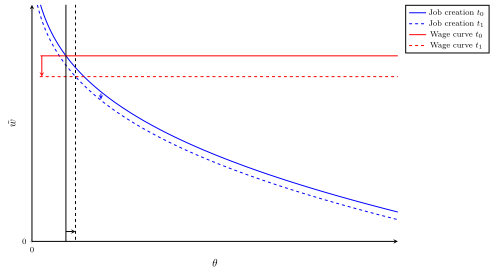

In [48]:
pgfplotsx()
p1 = plot(grid_theta_1, grid_wage, label=L"Job creation $t_0$", color="blue")
plot!(grid_theta_2, grid_wage, label=L"Job creation $t_1$", color="blue", linestyle=:dash)
plot!(grid_theta_1, grid_reservation_wage_1, label=L"Wage curve $t_0$", color="red")
plot!(grid_theta_2, grid_reservation_wage_2, label=L"Wage curve $t_1$", xticks=[0.0], yticks=[0.0], ylims=(0.0,maximum(grid_wage)), xlims=(0.0,0.8*maximum(grid_theta_2)), color="red", linestyle=:dash)
vline!([m.theta_2], color="black", label=:none) 
vline!([m_2.theta_2], color="black", linestyle=:dash, label=:none) 
xaxis!(draw_arrow=true, xlabel = L"\theta")
yaxis!(draw_arrow=true, ylabel= L"\tilde{w}")
plot!([m.theta_2[1], m_2.theta_2[1]], [0.05, 0.05], arrow=1., label=:none, color="black")
plot!([0.35, 0.35], [0.75, 0.72], arrow=1., label=:none, color="blue")
plot!([0.05, 0.05], [grid_reservation_wage_1[1], grid_reservation_wage_2[1]], arrow=1., label=:none, color="red")

#### V-U Space

In [49]:
function obj_ff(x, v, w_l, p)
    c = ((w_l/p.y) - p.mu_p)/p.sigma_p
    F = cdf(p.d_normal, c)
    theta = v/x[1]
    RHS = p.delta/(p.delta + (p.chi*(theta)^(1.0 - p.eta))*(1 - F))
    LHS = x[1]
    return 0.5*sqrt((RHS - LHS)^2)
end
    

function Beveridge_u(v, w_l, p)

    res = optimize(x -> obj_ff(x, v, w_l, p), [v])

    if Optim.converged(res) == true
        output = res.minimizer[1]
    else
        output = NaN
    end
    
    return output
end


Beveridge_u (generic function with 1 method)

In [50]:
# Find the Beveridge curve
v_min = 0.0095
v_max = 4*m.theta_2[1]*m.u_2[1]

grid_v = collect(range(v_min, v_max, nb_points))
grid_BC_1 = zeros(nb_points)
grid_BC_2 = zeros(nb_points)

for i=1:nb_points
    grid_BC_1[i] = Beveridge_u(grid_v[i], grid_reservation_wage_1[1], m.p)
    grid_BC_2[i] = Beveridge_u(grid_v[i], grid_reservation_wage_2[1], m.p)
end

# Calculate the job creation condition in the u-v space
u_min = 0.01
u_max = 0.15

grid_u = collect(range(u_min, u_max, nb_points))
grid_theta_bis_1 = zeros(nb_points)
grid_theta_bis_2 = zeros(nb_points);

for i=1:nb_points
    grid_theta_bis_1[i] = grid_u[i]*eq_theta(grid_reservation_wage_1[1], m.E_p_2[1], m.p)
    grid_theta_bis_2[i] = grid_u[i]*eq_theta(grid_reservation_wage_2[1], m_2.E_p_2[1], m_2.p)
end

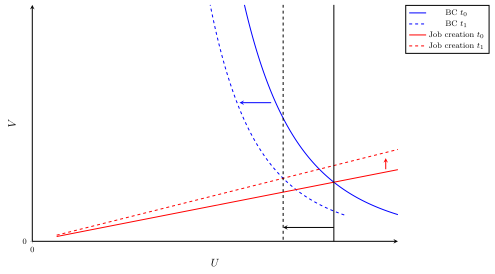

In [51]:
p2 = plot(grid_BC_1, grid_v, label=L"BC $t_0$", color="blue")
plot!(grid_BC_2, grid_v, label=L"BC $t_1$", color="blue", linestyle=:dash)
plot!(grid_u, grid_theta_bis_1, label=L"Job creation $t_0$", color="red")
plot!(grid_u, grid_theta_bis_2, label=L"Job creation $t_1$", xticks=[0.0], yticks=[0.0], color="red", linestyle=:dash, ylims=(0.0,v_max), xlims=(0.0, u_max))

vline!([m.u_2[1]], color="black", label=:none) 
vline!([m_2.u_2[1]], color="black", linestyle=:dash, label=:none) 

xaxis!(draw_arrow=true, xlabel = L"U")
yaxis!(draw_arrow=true, ylabel= L"V")

plot!([m.u_2[1], m_2.u_2[1]], [0.005, 0.005], arrow=1., label=:none, color="black")
plot!([0.098, 0.085], [0.05, 0.05], arrow=1., label=:none, color="blue")
plot!([0.145, 0.145], [0.026, 0.030], arrow=1., label=:none, color="red")


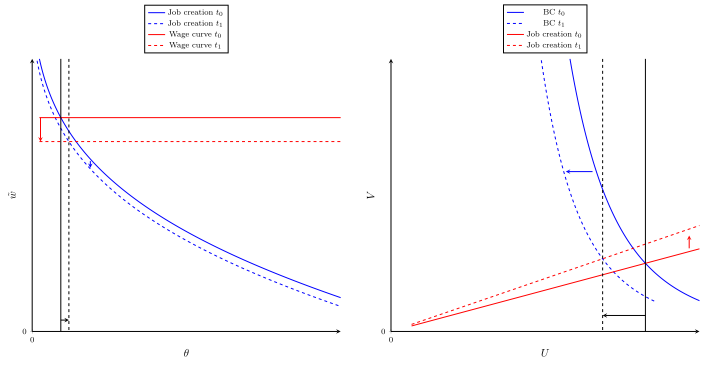

In [52]:
p0 = plot(p1, p2, dpi=1000, legend=:outertop)
ratio=9/20
w = 1000
h = w*ratio
plot!(size=(w,h))

savefig(p0, "equilibrium.png")
p0